# DualAQD: Dual Accuracy-quality-driven Prediction Intervals

This Google Colab implements the PI-generation method explained in the paper "[Dual Accuracy-Quality-Driven Neural Network for Prediction Interval Generation](https://arxiv.org/pdf/2212.06370.pdf)."

## Installation

Execute `!pip install git+https://github.com/NISL-MSU/PredictionIntervals` in the terminal.

In [ ]:
!pip install -q git+https://github.com/NISL-MSU/PredictionIntervals

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 334.7/334.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


## Load your data

Given a regression problem, you only need to provide two matrices: `X` (explainable variables) and `Y` (response variable) as numPy arrays.

In this example, we'll load a synthetic dataset:

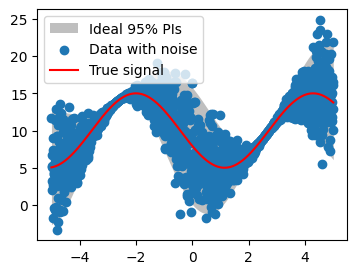

In [ ]:
import numpy as np
from PredictionIntervals.utils import create_synth_data
X, Y, P1, P2 = create_synth_data(n=1500, plot=True)

# Let's separate 1/3 of the data for training, 1/3 for validation, and 1/3 for test (modify these values to fit your needs)
indices = np.arange(len(Y))
np.random.seed(7)
np.random.shuffle(indices)
Xtrain, Ytrain = X[indices[:int(len(Y)/3)]], Y[indices[:int(len(Y)/3)]]
Xval, Yval = X[indices[int(len(Y)/3):int(len(Y)/3*2)]], Y[indices[int(len(Y)/3):int(len(Y)/3*2)]]
Xtest, Ytest = X[indices[int(len(Y)/3*2):]], Y[indices[int(len(Y)/3*2):]]

## Train the models

DualAQD uses two neural networks: a target-estimation network $f$ that is trained to generate accurate estimates, and a PI-generation NN $g$ that produces the upper and lower bounds of a prediction interval.

We'll start by creating an instance of the class `PredictionIntervalsTrainer.`

**Parameters**:

*   `X`: Input data (explainable variables). 2-D numpy array, shape (#samples, #features)
*   `Y`: Target data (response variable). 1-D numpy array, shape (#samples, #features)
*   `Xval`: Validation input data. 2-D numpy array, shape (#samples, #features)
*   `Yval`: Validation target data. 1-D numpy array, shape (#samples, #features)
*   `method`: PI-generation method. Options: 'DualAQD' or '[MCDropout](https://arxiv.org/pdf/1709.01907.pdf)'
*   `normData`: If True, apply z-score normalization to the inputs and min-max normalization to the outputs

**Note**: Normalization is applied to the training set; then, the exact same scaling is applied to the validation set.

In [ ]:
from PredictionIntervals.Trainer.TrainNN import Trainer
trainer = Trainer(X=Xtrain, Y=Ytrain, Xval=Xval, Yval=Yval)


To train the model, we'll call the `train` method.

**Parameters**:

*   `batch_size`: Mini batch size. It is recommended a small number. *default: 16*
*   `epochs`: Number of training epochs *default: 1000*
*   `eta_`: Scale factor used to update the self-adaptive coefficient lambda (Eq. 6 of the paper). *default: 0.01*
*   `printProcess`: If True, print the training process (loss and validation metrics after each epoch). *default: False*
*   `plotCurves`: If True, plot the training and validation curves at the end of the training process

**IMPORTANT**: This code is implemented using Pytorch. If you're running this on Google Colab, change the runtime type to GPU to accelerate the training process!

Training base model...


 71%|███████▏  | 1429/2000 [04:07<01:39,  5.77it/s]


Early stopping at epoch:  1429
Base model training complete!


 60%|██████    | 1200/2000 [07:24<04:56,  2.70it/s]

Early stopping at epoch:  1200



Validation performance:
Val MSE: 5.726753111596238 Val PICP: 0.949999988079071 Val MPIW: 7.315248966217041


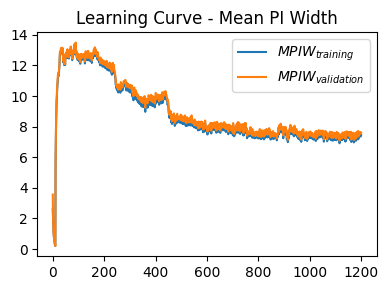

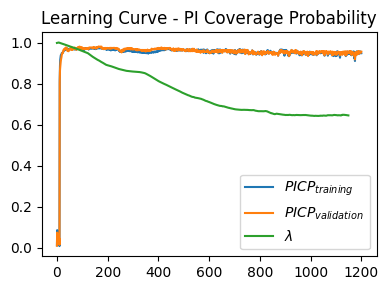

In [ ]:
trainer.train(printProcess=False, epochs=2000, batch_size=16, plotCurves=True)

It is worth mentioning that the loss function of DualAQD is $Loss_{DualAQD} = \mathcal{L}_1 + \lambda \, \mathcal{L}_2$; that is, it involves the minimization of two objectives. $\mathcal{L}_1$ is related to a penalization of the PI width (Eq. 3 of the paper), $\mathcal{L}_2$ enforces the PI integrity (Eq. 4), and $\lambda$ is a self-adaptive coefficient that controls the relative importance of $\mathcal{L}_1$ and $\mathcal{L}_2$.

From the second figure obtained by the previous cell, we notice the evolution of the $λ$ coefficient as it it tries the balance the trade-off between both objectives.

## Evaluate the model on the test set

To do this, we call the method `evaluate`.

**Parameters**:

*   `Xeval`: Evaluation data
*   `Yeval`: Optional. Evaluation targets. *default: None*
*   `normData`: If True, apply the same normalization that was applied to the training set

**Note**: `Yeval` is *None* in the case that the target values of the evaluation data are not known.

**Returns**:
*   If `Yeval` is *None*: It returns predictions `ypred, y_u, y_l` (i.e., target predictions, PI upper bounds, and PI lower bounds).
*   If `Yeval` is not *None*: It returns performance metrics and predictions `mse, PICP, MPIW, ypred, y_u, y_l` (i.e., mean square error of target predictions, PI coverage probability, mean PI width, target predictions, PI upper bounds, and PI lower bounds).




In [ ]:
val_mse, PICP, MPIW, ypred, y_u, y_l = trainer.evaluate(Xtest, Ytest, normData=True)
print('Test Performance:')
print("Test MSE: " + str(val_mse) + " Test PICP: " + str(PICP) + " Test MPIW: " + str(MPIW))

Test Performance:
Test MSE: 5.201604879034826 Test PICP: 0.9559999704360962 Test MPIW: 7.2122907638549805


## Plot Results

Text(0, 0.5, 'y')

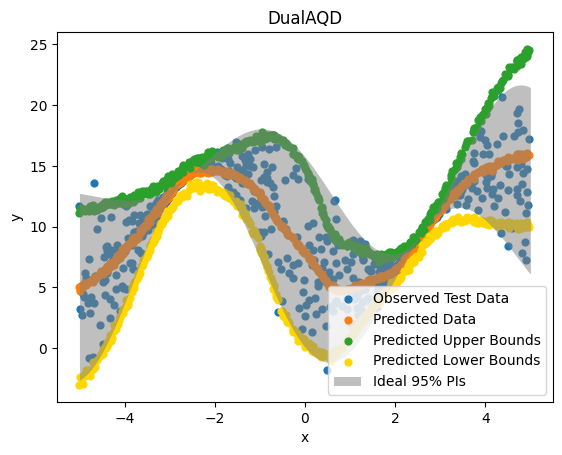

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(Xtest, Ytest, label='Observed Test Data', s=24)
plt.scatter(Xtest, ypred, label='Predicted Data', s=24)
plt.scatter(Xtest, y_u, label='Predicted Upper Bounds', s=24)
plt.scatter(Xtest, y_l, label='Predicted Lower Bounds', s=24, c='gold')
plt.fill_between(X, P1, P2, color='gray', alpha=0.5, linewidth=0, label='Ideal 95% PIs')
plt.legend(loc="lower right")
plt.title('DualAQD')
plt.xlabel('x')
plt.ylabel('y')